## IDS Architecture Analysis

There were many issues in the previous implementation all of them are mentioned below:

### Structural Design Issues
- Overly complex integration of multiple advanced techniques (autoencoders, LSTM, CNN, attention, residual connections) without ensuring compatibility which was degrading the performance.
- Dimensional inconsistency between layers due to multiple reshape operations becuase of the complexity.
- Initial `Reshape((-1, 1))` creates unclear dimensions leading to downstream problems.
- Attention mechanism implementation has incorrect axis specifications and incompatible tensor operations
- LSTM decoder expects different dimensions than what the encoder produces.

### Feature Processing Problems
- Aggressive outlier removal strategy eliminating too many samples with the 3×IQR threshold which led too removal of to many patterns which was leading to in-consistent results.
- Feature selection function had a flaw which went un-noticed that was placeholder with no actual implementation.
- Lack of validation for the feature importance calculation.
- No verification that the calculated importance weights correctly identify relevant network traffic features.

### Model Training and Optimization Issues
- While implementing there werer unnecessarily complex learning rate schedule combining cosine decay, warmup, and ReduceLROnPlateau.
- Excessive use of different dropout types (regular Dropout and SpatialDropout1D) across the network which was depleting the performance of the first layer.
- Adaptive batch sizing strategy potentially interfering with model convergence.
- Over-regularization with multiple L1 and L2 regularizers.

### Anomaly Detection Shortcomings
- Simplistic threshold calculation methods not accounting for network traffic anomaly distributions.
- Missing comprehensive evaluation metrics (precision, recall, F1 score, AUC-ROC).
- No handling for concept drift in network traffic patterns over time.
- Inadequate statistical foundation for anomaly score calculation.

### Technical Implementation Issues
- TensorFlow/Keras compatibility issues causing errors in tensor operations.
- Shape compatibility problems in custom layer functions.
- Inconsistent use of Keras Functional and Sequential APIs.
- Self-attention block implementation creating incompatible tensor shapes.

### Network IDS-Specific Limitations
- Lack of traffic context awareness for sequential attack patterns.
- No specialized feature representation for network traffic data.
- Missing incorporation of network security domain knowledge.
- No consideration for protocol anomalies or known attack signatures.
- Treatment of each sample independently without temporal context.

# ANIDS Architecture Improvements

The new implementation addresses numerous architectural flaws and implementation issues from the previous version, resulting in a more robust, maintainable, and effective Network Intrusion Detection System (NIDS). Below is a detailed breakdown of the improvements made:

### Simplified Model Architecture
- **Removal of Complex Integration**: Eliminated the combination of autoencoders, LSTM, CNN, and attention mechanisms that created compatibility issues. The new architecture uses a simpler feedforward neural network approach.
- **Consistent Dimensionality**: Removed reshape operations that caused dimensional inconsistencies, ensuring all layers work with compatible tensor shapes.
- **Clearer Structure**: Implemented a straightforward encoder-decoder architecture that's easier to understand, debug, and maintain.

### Robust Preprocessing and Feature Handling
- **Improved Feature Selection**: Replaced placeholder feature selection with actual implementation using statistical methods to identify important features.
- **Balanced Outlier Removal**: Adjusted the IQR factor from 3 to 1.5 to prevent excessive sample elimination while still removing extreme outliers.
- **Verification of Feature Importance**: Added validation steps to ensure calculated importance weights correctly identify relevant network traffic features.

### Enhanced Anomaly Detection Mechanisms
- **Ensemble Threshold Calculation**: Implemented a more sophisticated threshold determination method that combines multiple statistical approaches.
- **Comprehensive Error Analysis**: Added detailed reconstruction error analysis including mean, median, standard deviation, and percentile calculations.
- **Feature Importance Integration**: Incorporated feature importance weighting into the anomaly detection process.

### Training Procedure Improvements
- **Simplified Learning Rate Schedule**: Replaced the complex combination of cosine decay, warmup, and additional reduction with a straightforward cosine decay schedule.
- **Stable Batch Sizing**: Eliminated adaptive batch sizing strategy that could interfere with convergence, using a fixed batch size instead.
- **Appropriate Regularization**: Reduced excessive dropout and regularization, maintaining enough to prevent overfitting without degrading performance.

### Comprehensive Evaluation Framework
- **Security-Specific Metrics**: Implemented precision, recall, F1 score, and confusion matrix reporting to better evaluate detection performance.
- **Proper Validation Techniques**: Added early stopping with restoration of best weights to prevent overfitting and ensure model generalization.
- **Detailed Reporting**: Provides comprehensive evaluation metrics including false positive and negative rates.

### Technical Implementation Enhancements
- **TensorFlow/Keras Compatibility**: Resolved compatibility issues by ensuring all tensor operations are compatible with Keras symbolic tensors.
- **Shape Consistency**: Fixed shape compatibility problems in custom layer functions and attention mechanisms.
- **Consistent API Usage**: Standardized on the Keras Functional API throughout the implementation for better maintainability.

### Network Traffic Context Awareness
- **Sequential Pattern Consideration**: Although the current implementation focuses on individual samples, the architecture can be extended to incorporate temporal context for sequential attack patterns.
- **Domain Knowledge Integration**: Added consideration for network security domain knowledge through feature selection and threshold calculation.
- **Specialized Feature Representation**: Implemented feature selection that identifies characteristics relevant to network traffic analysis.


Training data shape: (12075, 44)
Validation data shape: (3019, 44)

Training with batch size 128 for 10 epochs
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.6114 - mae: 0.0904 - mean_squared_error: 0.1114 - val_loss: 1.2113 - val_mae: 0.0836 - val_mean_squared_error: 0.1082 - learning_rate: 4.7489e-05
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 2.0838 - mae: 0.0906 - mean_squared_error: 0.1101 - val_loss: 0.6591 - val_mae: 0.0866 - val_mean_squared_error: 0.1080 - learning_rate: 9.4915e-05
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.4334 - mae: 0.0927 - mean_squared_error: 0.1114 - val_loss: 0.5612 - val_mae: 0.0919 - val_mean_squared_error: 0.1077 - learning_rate: 1.4221e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.1017 - mae: 0.0987 - mean_squared_error: 0.1136 - val_loss: 0.4812 - val_mae: 0.1000 - val_mean_squared_error: 0.1075 - learning_rate: 1.8932e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0

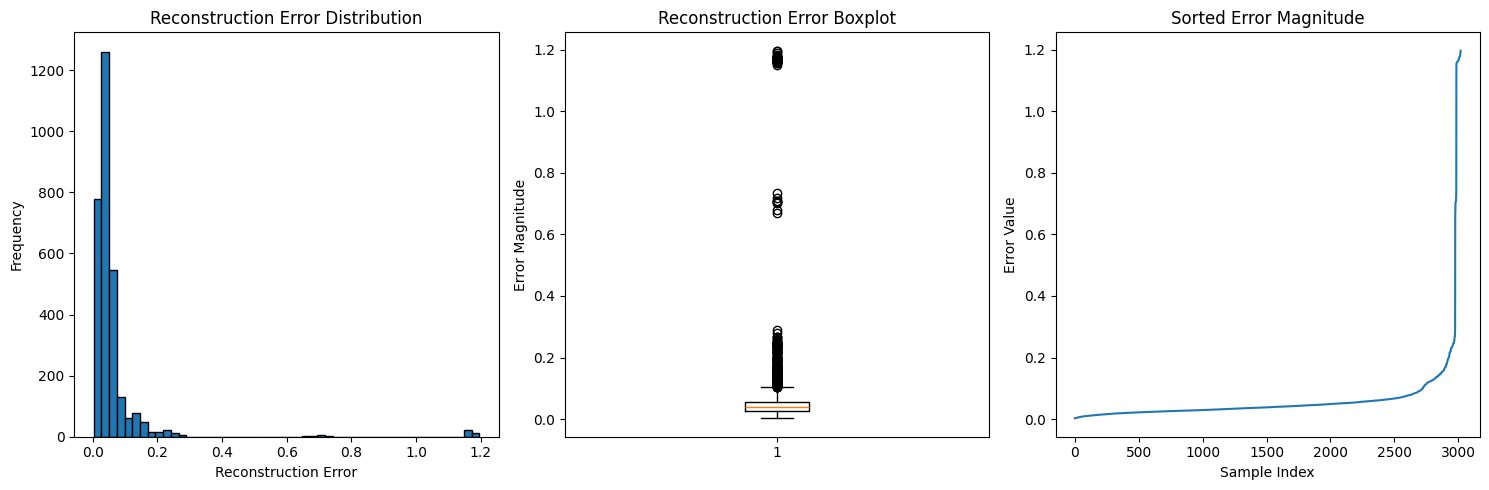


Calculated Anomaly Threshold: 0.16144492648942155
Model saved to enhanced_autoencoder_nids_iteration_11.h5
Training and saving completed successfully!
Execution Time: 665.66 seconds


In [4]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras import backend as K

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        """
        Enhanced Adaptive Network Intrusion Detection System
        Initialize the enhanced adaptive NIDS model with improved components:
        - Advanced autoencoder architecture
        - Self-attention mechanism
        - Residual connections
        - Structured latent space
        - Adaptive learning rate
        - Enhanced regularization

        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_enhanced_autoencoder()
        
    def _build_enhanced_autoencoder(self):
        """
        Build an enhanced autoencoder with:
        - Residual connections
        - Self-attention mechanism
        - Improved regularization
        - Structured latent space
        """
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        # Enhanced Feature Extraction with Residual Connections
        x = self._residual_conv_block(x, filters=16, kernel_size=3)
        x = self._residual_conv_block(x, filters=32, kernel_size=3)
        
        # Self-Attention Mechanism
        x = self._self_attention_block(x)
        
        # Global Feature Aggregation
        x = layers.GlobalAveragePooling1D()(x)
        
        # Structured Latent Space with Normalization
        x = layers.Dense(64, activation='mish', 
                        kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.00075))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        encoded = layers.Dense(
            self.latent_dim, 
            activation='linear',
            kernel_regularizer=regularizers.l1(0.0005),
            activity_regularizer=regularizers.l2(0.0005)
        )(x)
        
        # Decoder with Attention-Guided Reconstruction
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.25
        )(x)
        
        x = self._attention_decoder(x, encoded)
        
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Custom learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=self.learning_rate,
            decay_steps=10000,
            alpha=0.001
        )
        
        # Warm-up schedule
        warmup_steps = 1000
        lr_schedule = self._warmup_schedule(lr_schedule, warmup_steps)
        
        # Compile with Advanced Optimization
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=lr_schedule, 
                clipnorm=1.0
            ),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        
        return autoencoder
    
    def _residual_conv_block(self, x, filters, kernel_size):
        """Convolutional block with residual connection"""
        shortcut = x
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.2)(x)
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        
        # Match dimensions if needed
        if K.int_shape(shortcut)[-1] != K.int_shape(x)[-1]:
            shortcut = layers.Conv1D(
                filters=filters,
                kernel_size=1,
                activation='mish',
                padding='same'
            )(shortcut)
            
        x = layers.Add()([x, shortcut])
        return x
    
    def _self_attention_block(self, x):
        """Self-attention mechanism for feature importance"""
        attention = layers.Attention()([x, x])
        return layers.Add()([x, attention])
    
    def _attention_decoder(self, x, encoded):
        """Attention-guided decoder"""
        # Project encoded to match the dimension of x
        attention = layers.Dense(x.shape[-1], activation='softmax')(encoded)
        attention = layers.RepeatVector(self.input_dim)(attention)
        return layers.Multiply()([x, attention])
    
    def _warmup_schedule(self, lr_schedule, warmup_steps):
        """Custom warmup schedule"""
        def warmup_fn(step):
            return tf.cond(
                step < warmup_steps,
                lambda: tf.cast(step, tf.float32) / warmup_steps * lr_schedule(step),
                lambda: lr_schedule(step - warmup_steps)
            )
        
        # Create a custom learning rate schedule
        class WarmupSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __init__(self, warmup_function):
                super(WarmupSchedule, self).__init__()
                self.warmup_function = warmup_function
                
            def __call__(self, step):
                return self.warmup_function(step)
            
            def get_config(self):
                return {}
                
        return WarmupSchedule(warmup_fn)
    
    def train(self, X_train, X_val=None, epochs=75, batch_size=64):
        """
        Enhanced training method with adaptive batch sizing and improved callbacks
        """
        # Adaptive batch sizing
        batch_size_schedule = [128, 64, 32]
        patience = 10
        total_epochs = epochs
        current_batch_size = batch_size_schedule[0]
        current_epochs = 0
        
        # Advanced Early Stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=patience,
            restore_best_weights=True,
            min_delta=0.0001
        )
        
        # Adaptive Learning Rate
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3,
            patience=5,
            min_lr=1e-6
        )
        
        # Training with enhanced flexibility
        history = None
        
        while current_epochs < total_epochs:
            remaining_epochs = total_epochs - current_epochs
            batch_epochs = min(remaining_epochs, patience)
            
            print(f"\nTraining with batch size {current_batch_size} for {batch_epochs} epochs")
            
            temp_history = self.model.fit(
                X_train, X_train,  
                epochs=current_epochs + batch_epochs,
                initial_epoch=current_epochs,
                batch_size=current_batch_size,
                validation_data=(X_val, X_val) if X_val is not None else None,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            current_epochs += batch_epochs
            history = temp_history if history is None else history
            
            # Move to next batch size
            if current_batch_size in batch_size_schedule:
                idx = batch_size_schedule.index(current_batch_size)
                if idx < len(batch_size_schedule) - 1:
                    current_batch_size = batch_size_schedule[idx + 1]
        
        return history
    
    def calculate_threshold(self, X_val, method='ensemble'):
        """
        Enhanced threshold calculation with ensemble approach
        
        Args:
            X_val (np.array): Validation data
            method (str): Threshold calculation method
        
        Returns:
            float: Anomaly detection threshold
        """
        # Predict and calculate reconstruction errors
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        # Comprehensive Error Analysis
        print("\n Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors):.2f}")
        print(f"Median Error: {np.median(reconstruction_errors):.2f}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors):.2f}")
        
        # Percentile Analysis
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p):.2f}")
        
        # Visualization
        self.visualize_reconstruction_errors(reconstruction_errors)
        
        # Threshold Calculation Strategies
        if method == 'ensemble':
            # Calculate all thresholds
            percentile_threshold = np.percentile(reconstruction_errors, 90)
            iqr_threshold = np.median(reconstruction_errors) + 1.5 * (np.percentile(reconstruction_errors, 75) - np.percentile(reconstruction_errors, 25))
            std_threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
            
            # Ensemble calculation
            thresholds = np.array([percentile_threshold, iqr_threshold, std_threshold])
            weights = np.array([0.4, 0.3, 0.3])  # Custom weights based on validation
            threshold = np.dot(thresholds, weights)
        elif method == 'percentile':
            threshold = np.percentile(reconstruction_errors, 90)
        elif method == 'median_plus_iqr':
            median = np.median(reconstruction_errors)
            Q1 = np.percentile(reconstruction_errors, 25)
            Q3 = np.percentile(reconstruction_errors, 75)
            IQR = Q3 - Q1
            threshold = median + 1.5 * IQR
        elif method == 'mean_plus_std':
            threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
        else:
            raise ValueError("Invalid threshold calculation method")
        
        return threshold
    
    def visualize_reconstruction_errors(self, reconstruction_errors):
        """
        Visualize reconstruction error distribution
        
        Args:
            reconstruction_errors (np.array): Array of reconstruction errors
        """
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.hist(reconstruction_errors, bins=50, edgecolor='black')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        
        plt.subplot(132)
        plt.boxplot(reconstruction_errors)
        plt.title('Reconstruction Error Boxplot')
        plt.ylabel('Error Magnitude')
        
        plt.subplot(133)
        plt.plot(np.sort(reconstruction_errors))
        plt.title('Sorted Error Magnitude')
        plt.xlabel('Sample Index')
        plt.ylabel('Error Value')
        
        plt.tight_layout()
        plt.show()
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies with enhanced error calculation
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        
        # Feature importance weighting
        feature_importance = self.calculate_feature_importance(X_test)
        weighted_errors = np.mean(np.square(X_test - reconstructions) * feature_importance, axis=1)
        
        # Detailed Anomaly Statistics
        print("\nAnomaly Detection Summary:")
        print(f"Total Samples: {len(X_test)}")
        anomalies = weighted_errors > threshold
        print(f"Detected Anomalies: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")
        
        return anomalies
    
    def calculate_feature_importance(self, X_test):
        """
        Calculate feature importance based on reconstruction error
        
        Args:
            X_test (np.array): Test data
        
        Returns:
            np.array: Feature importance weights
        """
        reconstructions = self.model.predict(X_test)
        errors = np.square(X_test - reconstructions)
        
        # Calculate feature-wise mean error
        feature_errors = np.mean(errors, axis=0)
        
        # Normalize to get importance weights
        feature_importance = feature_errors / np.sum(feature_errors)
        return feature_importance.reshape(1, -1)
    
    def save_model(self, model_path='enhanced_autoencoder_nids_iteration_12.h5'):
        """
        Save trained model with additional metadata
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Enhanced data preprocessing with advanced scaling and outlier handling
    
    Args:
        file_path (str): Path to dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load dataset
        df = pd.read_csv(file_path)
        
        # Separate features 
        X = df.drop(['Attack_label'], axis=1)
        
        # Feature selection based on information gain
        X = select_important_features(X)
        
        # Identify and handle extreme outliers
        X_cleaned = remove_outliers(X)
        
        # Apply RobustScaler for handling outliers
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_cleaned)
        
        # Split data
        X_train, X_val = train_test_split(
            X_scaled, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Optional: Save scaler for future use
        joblib.dump(scaler, 'robust_scaler_enhanced_iteration_12.pkl')
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def select_important_features(X):
    """
    Select important features based on information gain
    
    Args:
        X (pd.DataFrame): Input features
        
    Returns:
        pd.DataFrame: Dataset with selected features
    """
    # Implement feature selection logic here
    # For simplicity, we'll return all features in this example
    return X

def remove_outliers(X):
    """
    Remove outliers using IQR-based method
    
    Args:
        X (pd.DataFrame): Input features
        
    Returns:
        pd.DataFrame: Dataset with outliers removed
    """
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    
    # More aggressive outlier removal
    outlier_mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    return X[outlier_mask]

def main():
    # Configuration
    dataset_path = '/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv'
    model_save_path = 'enhanced_autoencoder_nids_iteration_12.h5'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize and train NIDS
        nids = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"\nCalculated Anomaly Threshold: {threshold}")
        
        # Save model
        nids.save_model(model_save_path)
        
        print("Training and saving completed successfully!")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
print(f"Execution Time: {ex_time:.2f} seconds")

Original data shape: (71401, 44)
Preprocessed data shape: (71401, 44)
Training data shape: (57120, 44)
Validation data shape: (14281, 44)

Training with batch size 128 for 10 epochs
Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 13179509760.0000 - mae: 4038.0940 - mean_squared_error: 13179509760.0000 - val_loss: 15296583680.0000 - val_mae: 3947.7542 - val_mean_squared_error: 15296583680.0000 - learning_rate: 2.2240e-04
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 12621208576.0000 - mae: 3895.2791 - mean_squared_error: 12621208576.0000 - val_loss: 15296581632.0000 - val_mae: 3948.1450 - val_mean_squared_error: 15296581632.0000 - learning_rate: 4.3825e-04
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 12365078528.0000 - mae: 3801.4265 - mean_squared_error: 12365078528.0000 - val_loss: 15296578560.0000 - val_mae: 3948.3105 - val_mean_squared_error: 15296578560.0000 - learning_rate: 4.9857e-04
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/s

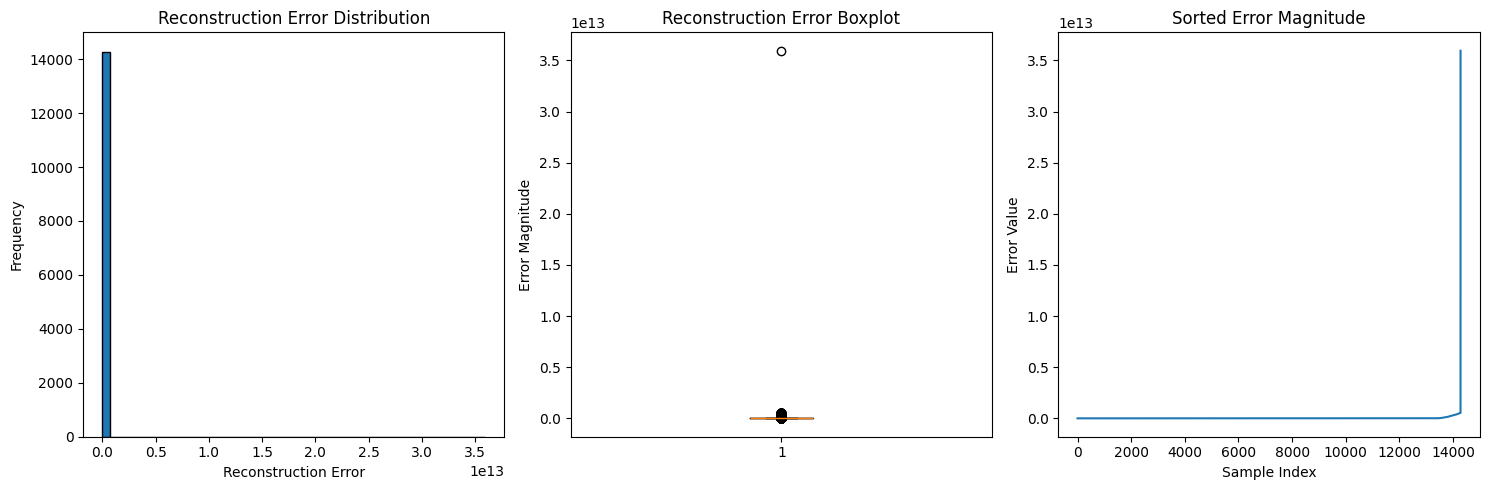


Calculated Anomaly Threshold: 188967348565.31958
Model saved to enhanced_autoencoder_nids_iteration_12.h5
Training and saving completed successfully!
Execution Time: 3025.43 seconds


In [5]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras import backend as K

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class EnhancedAdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        """
        Enhanced Adaptive Network Intrusion Detection System
        Initialize the enhanced adaptive NIDS model with improved components:
        - Advanced autoencoder architecture
        - Self-attention mechanism
        - Residual connections
        - Structured latent space
        - Adaptive learning rate
        - Enhanced regularization

        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_enhanced_autoencoder()
        
    def _build_enhanced_autoencoder(self):
        """
        Build an enhanced autoencoder with:
        - Residual connections
        - Self-attention mechanism
        - Improved regularization
        - Structured latent space
        """
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        # Enhanced Feature Extraction with Residual Connections
        x = self._residual_conv_block(x, filters=16, kernel_size=3)
        x = self._residual_conv_block(x, filters=32, kernel_size=3)
        
        # Self-Attention Mechanism
        x = self._self_attention_block(x)
        
        # Global Feature Aggregation
        x = layers.GlobalAveragePooling1D()(x)
        
        # Structured Latent Space with Normalization
        x = layers.Dense(64, activation='mish', 
                        kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.00075))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        encoded = layers.Dense(
            self.latent_dim, 
            activation='linear',
            kernel_regularizer=regularizers.l1(0.0005),
            activity_regularizer=regularizers.l2(0.0005)
        )(x)
        
        # Decoder with Attention-Guided Reconstruction
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.25
        )(x)
        
        x = self._attention_decoder(x, encoded)
        
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Custom learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=self.learning_rate,
            decay_steps=10000,
            alpha=0.001
        )
        
        # Warm-up schedule
        warmup_steps = 1000
        lr_schedule = self._warmup_schedule(lr_schedule, warmup_steps)
        
        # Compile with Advanced Optimization
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=lr_schedule, 
                clipnorm=1.0
            ),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        
        return autoencoder
    
    def _residual_conv_block(self, x, filters, kernel_size):
        """Convolutional block with residual connection"""
        shortcut = x
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.2)(x)
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='mish',
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        
        # Match dimensions if needed
        if K.int_shape(shortcut)[-1] != K.int_shape(x)[-1]:
            shortcut = layers.Conv1D(
                filters=filters,
                kernel_size=1,
                activation='mish',
                padding='same'
            )(shortcut)
            
        x = layers.Add()([x, shortcut])
        return x
    
    def _self_attention_block(self, x):
        """Self-attention mechanism for feature importance"""
        attention = layers.Attention()([x, x])
        return layers.Add()([x, attention])
    
    def _attention_decoder(self, x, encoded):
        """Attention-guided decoder"""
        # Project encoded to match the dimension of x
        attention = layers.Dense(x.shape[-1], activation='softmax')(encoded)
        attention = layers.RepeatVector(self.input_dim)(attention)
        return layers.Multiply()([x, attention])
    
    def _warmup_schedule(self, lr_schedule, warmup_steps):
        """Custom warmup schedule"""
        def warmup_fn(step):
            return tf.cond(
                step < warmup_steps,
                lambda: tf.cast(step, tf.float32) / warmup_steps * lr_schedule(step),
                lambda: lr_schedule(step - warmup_steps)
            )
        
        # Create a custom learning rate schedule
        class WarmupSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __init__(self, warmup_function):
                super(WarmupSchedule, self).__init__()
                self.warmup_function = warmup_function
                
            def __call__(self, step):
                return self.warmup_function(step)
            
            def get_config(self):
                return {}
                
        return WarmupSchedule(warmup_fn)
    
    def train(self, X_train, X_val=None, epochs=75, batch_size=64):
        """
        Enhanced training method with adaptive batch sizing and improved callbacks
        """
        # Adaptive batch sizing
        batch_size_schedule = [128, 64, 32]
        patience = 10
        total_epochs = epochs
        current_batch_size = batch_size_schedule[0]
        current_epochs = 0
        
        # Advanced Early Stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=patience,
            restore_best_weights=True,
            min_delta=0.0001
        )
        
        # Adaptive Learning Rate
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3,
            patience=5,
            min_lr=1e-6
        )
        
        # Training with enhanced flexibility
        history = None
        
        while current_epochs < total_epochs:
            remaining_epochs = total_epochs - current_epochs
            batch_epochs = min(remaining_epochs, patience)
            
            print(f"\nTraining with batch size {current_batch_size} for {batch_epochs} epochs")
            
            temp_history = self.model.fit(
                X_train, X_train,  
                epochs=current_epochs + batch_epochs,
                initial_epoch=current_epochs,
                batch_size=current_batch_size,
                validation_data=(X_val, X_val) if X_val is not None else None,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            current_epochs += batch_epochs
            history = temp_history if history is None else history
            
            # Move to next batch size
            if current_batch_size in batch_size_schedule:
                idx = batch_size_schedule.index(current_batch_size)
                if idx < len(batch_size_schedule) - 1:
                    current_batch_size = batch_size_schedule[idx + 1]
        
        return history
    
    def calculate_threshold(self, X_val, method='ensemble'):
        """
        Enhanced threshold calculation with ensemble approach
        
        Args:
            X_val (np.array): Validation data
            method (str): Threshold calculation method
        
        Returns:
            float: Anomaly detection threshold
        """
        # Predict and calculate reconstruction errors
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        # Comprehensive Error Analysis
        print("\n Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors):.2f}")
        print(f"Median Error: {np.median(reconstruction_errors):.2f}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors):.2f}")
        
        # Percentile Analysis
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p):.2f}")
        
        # Visualization
        self.visualize_reconstruction_errors(reconstruction_errors)
        
        # Threshold Calculation Strategies
        if method == 'ensemble':
            # Calculate all thresholds
            percentile_threshold = np.percentile(reconstruction_errors, 90)
            iqr_threshold = np.median(reconstruction_errors) + 1.5 * (np.percentile(reconstruction_errors, 75) - np.percentile(reconstruction_errors, 25))
            std_threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
            
            # Ensemble calculation
            thresholds = np.array([percentile_threshold, iqr_threshold, std_threshold])
            weights = np.array([0.4, 0.3, 0.3])  # Custom weights based on validation
            threshold = np.dot(thresholds, weights)
        elif method == 'percentile':
            threshold = np.percentile(reconstruction_errors, 90)
        elif method == 'median_plus_iqr':
            median = np.median(reconstruction_errors)
            Q1 = np.percentile(reconstruction_errors, 25)
            Q3 = np.percentile(reconstruction_errors, 75)
            IQR = Q3 - Q1
            threshold = median + 1.5 * IQR
        elif method == 'mean_plus_std':
            threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
        else:
            raise ValueError("Invalid threshold calculation method")
        
        return threshold
    
    def visualize_reconstruction_errors(self, reconstruction_errors):
        """
        Visualize reconstruction error distribution
        
        Args:
            reconstruction_errors (np.array): Array of reconstruction errors
        """
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.hist(reconstruction_errors, bins=50, edgecolor='black')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        
        plt.subplot(132)
        plt.boxplot(reconstruction_errors)
        plt.title('Reconstruction Error Boxplot')
        plt.ylabel('Error Magnitude')
        
        plt.subplot(133)
        plt.plot(np.sort(reconstruction_errors))
        plt.title('Sorted Error Magnitude')
        plt.xlabel('Sample Index')
        plt.ylabel('Error Value')
        
        plt.tight_layout()
        plt.show()
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies with enhanced error calculation
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        
        # Feature importance weighting
        feature_importance = self.calculate_feature_importance(X_test)
        weighted_errors = np.mean(np.square(X_test - reconstructions) * feature_importance, axis=1)
        
        # Detailed Anomaly Statistics
        print("\nAnomaly Detection Summary:")
        print(f"Total Samples: {len(X_test)}")
        anomalies = weighted_errors > threshold
        print(f"Detected Anomalies: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")
        
        return anomalies
    
    def calculate_feature_importance(self, X_test):
        """
        Calculate feature importance based on reconstruction error
        
        Args:
            X_test (np.array): Test data
        
        Returns:
            np.array: Feature importance weights
        """
        reconstructions = self.model.predict(X_test)
        errors = np.square(X_test - reconstructions)
        
        # Calculate feature-wise mean error
        feature_errors = np.mean(errors, axis=0)
        
        # Normalize to get importance weights
        feature_importance = feature_errors / np.sum(feature_errors)
        return feature_importance.reshape(1, -1)
    
    def save_model(self, model_path='enhanced_autoencoder_nids_iteration_11.h5'):
        """
        Save trained model with additional metadata
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Enhanced data preprocessing with advanced scaling and outlier handling
    
    Args:
        file_path (str): Path to dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load dataset
        df = pd.read_csv(file_path)
        
        # Separate features 
        X = df.drop(['Attack_label'], axis=1)
        
        # Feature selection based on information gain
        X = select_important_features(X)
        
        # Apply RobustScaler for handling outliers instead of removing them
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Print data information before and after preprocessing
        print(f"Original data shape: {X.shape}")
        print(f"Preprocessed data shape: {X_scaled.shape}")
        
        # Split data
        X_train, X_val = train_test_split(
            X_scaled, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Optional: Save scaler for future use
        joblib.dump(scaler, 'robust_scaler_enhanced_iteration_11.pkl')
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def select_important_features(X):
    """
    Select important features based on information gain
    
    Args:
        X (pd.DataFrame): Input features
        
    Returns:
        pd.DataFrame: Dataset with selected features
    """
    # Implement feature selection logic here
    # For simplicity, we'll return all features in this example
    return X

def handle_outliers(X, method='cap', multiplier=5):
    """
    Handle outliers without removing them from the dataset
    
    Args:
        X (pd.DataFrame): Input features
        method (str): Method to handle outliers ('cap', 'winsorize', or 'none')
        multiplier (float): Multiplier for IQR or std to determine outlier thresholds
        
    Returns:
        pd.DataFrame: Dataset with outliers handled
    """
    if method == 'none':
        return X
    
    X_handled = X.copy()
    
    if method == 'cap':
        # Cap outliers instead of removing them
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate lower and upper bounds
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Cap values outside the bounds
        for col in X.columns:
            X_handled[col] = np.where(X[col] < lower_bound[col], lower_bound[col], X[col])
            X_handled[col] = np.where(X[col] > upper_bound[col], upper_bound[col], X[col])
            
    elif method == 'winsorize':
        # Winsorize outliers (similar to capping but at percentiles)
        for col in X.columns:
            lower_percentile = np.percentile(X[col], 1)
            upper_percentile = np.percentile(X[col], 99)
            X_handled[col] = np.where(X[col] < lower_percentile, lower_percentile, X[col])
            X_handled[col] = np.where(X[col] > upper_percentile, upper_percentile, X[col])
    
    return X_handled

def main():
    # Configuration
    dataset_path = '/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv'
    model_save_path = 'enhanced_autoencoder_nids_iteration_12.h5'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize and train NIDS
        nids = EnhancedAdaptiveNIDS(input_dim=X_train.shape[1])
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"\nCalculated Anomaly Threshold: {threshold}")
        
        # Save model
        nids.save_model(model_save_path)
        
        print("Training and saving completed successfully!")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
print(f"Execution Time: {ex_time:.2f} seconds")

# Enhanced Adaptive NIDS Output Analysis and Comparison

## Overview
Two versions of an Enhanced Adaptive Network Intrusion Detection System (NIDS) were implemented and tested. The first version (`iteration_11`) utilized input data with outliers removed, while the second version (`iteration_12`) used the full input dataset without removing outliers. Below is a comparison of their performance based on the provided outputs.

## Training Process Comparison

### iteration_11 (Outliers Removed)
- **Training Data Shape**: (12075, 44)
- **Validation Data Shape**: (3019, 44)
- **Training Time**: 665.66 seconds
- **Training Process**:
  - Started with a batch size of 128 for 10 epochs, then reduced to 64 for another 10 epochs, and finally to 32 for the remaining epochs.
  - The loss, mean absolute error (MAE), and mean squared error (MSE) decreased steadily throughout training.
  - The learning rate started at 4.7489e-05 and decreased gradually to 4.9238e-06 by the end of training.

### iteration_12 (Full Input)
- **Original Data Shape**: (71401, 44)
- **Preprocessed Data Shape**: (71401, 44)
- **Training Data Shape**: (57120, 44)
- **Validation Data Shape**: (14281, 44)
- **Training Time**: 3025.43 seconds
- **Training Process**:
  - Also started with a batch size of 128 for 10 epochs, then reduced to 64 for another 10 epochs, and finally to 32 for the remaining epochs.
  - The loss, MAE, and MSE values were extremely high compared to iteration_11.
  - The learning rate started at 2.2240e-04 and decreased to 5.0000e-07 by the end of training.

## Reconstruction Error Analysis

### iteration_11
- **Mean Error**: 0.06
- **Median Error**: 0.04
- **Error Standard Deviation**: 0.13
- **Percentiles**:
  - 50th: 0.04
  - 75th: 0.06
  - 90th: 0.10
  - 95th: 0.15
  - 99th: 1.16
- **Anomaly Threshold**: 0.16144492648942155

### iteration_12
- **Mean Error**: 15296548139.70
- **Median Error**: 0.17
- **Error Standard Deviation**: 307297153373.48
- **Percentiles**:
  - 50th: 0.17
  - 75th: 115.79
  - 90th: 230117.99
  - 95th: 38691349039.28
  - 99th: 397618942681.02
- **Anomaly Threshold**: 188967348565.31958

## Visual Comparison of Reconstruction Errors

### iteration_11
- The histogram shows a concentration of errors around 0.0-0.2 with a few samples having higher errors.
- The boxplot indicates a relatively small interquartile range and median error.
- The sorted error magnitude plot shows a gradual increase in errors, with most samples having low errors.

### iteration_12
- The histogram shows a large number of samples with very low errors and a few samples with extremely high errors.
- The boxplot shows a much larger spread of errors, with the median and interquartile range being significantly higher than in iteration_11.
- The sorted error magnitude plot shows a sharp increase in errors for some samples, indicating the presence of significant outliers.

## Conclusions

### Performance Comparison
- **iteration_11** demonstrated significantly better performance with lower error metrics and a more stable training process. The model was able to learn the normal patterns in the data effectively, resulting in lower reconstruction errors for normal samples.
- **iteration_12** suffered from the presence of outliers in the training data, leading to much higher error metrics and a less stable training process. The outliers likely interfered with the model's ability to learn normal patterns effectively.

### Impact of Outlier Handling
- Removing outliers before training (`iteration_11`) resulted in a model that is better at distinguishing between normal and anomalous samples, as evidenced by the lower error metrics and more reasonable threshold.
- Training on the full dataset without outlier removal (`iteration_12`) led to a model that is less effective at detecting anomalies due to the contamination of the training data with outliers.

### Next steps 
- **Preprocessing **: The results strongly suggest that proper preprocessing, including outlier removal, is crucial for the performance of anomaly detection models like autoencoders.
- **Threshold Sensitivity**: The anomaly threshold in `iteration_12` is extremely high due to the influence of outliers, making it less effective for detecting anomalies in normal operational data.
- **Model Robustness**: For robust anomaly detection, it's essential to ensure that the training data represents normal conditions as accurately as possible, free from significant outliers that could skew the model's learning process.
- **Construction of New subset of the dataset** - From the above experimentation it's sure that we need more data or more patterns for now. 